In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import constraints
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score
from scipy.interpolate import CubicSpline
import time
from tqdm import tqdm
import umap.umap_ as umap
from sklearn.preprocessing import LabelEncoder
from scipy.interpolate import UnivariateSpline

In [2]:
%config InlineBackend.figure_format = 'svg'

In [3]:
df=pd.read_excel('Original_data_conductance.xlsx', sheet_name='N=200')
timepoints=len(df)//2

# === Load Data ===
G_pot = df['Conductance'].values[:timepoints]
G_dep = df['Conductance'].values[timepoints:]
pulse_numbers = np.arange(300)+1

# === Compute ΔG / G0 ===
dG_pot = np.diff(G_pot) / (G_pot[:-1] + 1e-7)
dG_dep = np.diff(G_dep) / (G_dep[:-1] + 1e-7)

In [4]:
# === Map to Δt ===
delta_t_pot_STDP = np.linspace(0, 1, len(dG_pot))     # LTP
delta_t_dep_STDP  = np.linspace(0, -1, len(dG_dep))   # LTD

# === Construct DataFrame ===
data = {
    'Delta_t': np.concatenate([delta_t_dep_STDP, delta_t_pot_STDP]),
    'Delta_G/G0': np.concatenate([dG_dep, dG_pot])
}
stdp_df = pd.DataFrame(data)

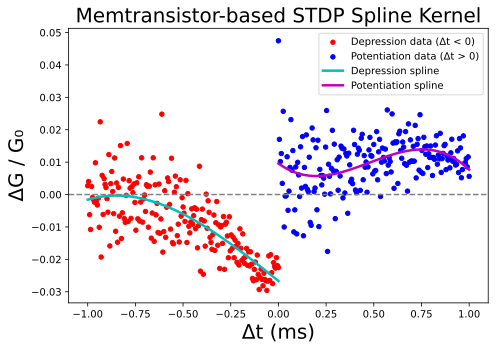

In [5]:
# === Sort Δt values (important for spline fitting) ===
sort_pot = np.argsort(delta_t_pot_STDP)
sort_dep = np.argsort(delta_t_dep_STDP)

delta_t_pot_sorted = delta_t_pot_STDP[sort_pot]
delta_g_pot_sorted = dG_pot[sort_pot]

delta_t_dep_sorted = delta_t_dep_STDP[sort_dep]
delta_g_dep_sorted = dG_dep[sort_dep]

# === Fit Cubic Splines ===
#spline_pot = CubicSpline(delta_t_pot_sorted, delta_g_pot_sorted)
#spline_dep = CubicSpline(delta_t_dep_sorted, delta_g_dep_sorted)

# === Fit Smooth Splines ===
spline_pot = UnivariateSpline(delta_t_pot_sorted, delta_g_pot_sorted, s=0.1)
spline_dep = UnivariateSpline(delta_t_dep_sorted, delta_g_dep_sorted, s=0.01)

# === Evaluate splines for smooth plotting ===
t_pot_fine = np.linspace(delta_t_pot_sorted.min(), delta_t_pot_sorted.max(), 300)
t_dep_fine = np.linspace(delta_t_dep_sorted.min(), delta_t_dep_sorted.max(), 300)
g_pot_fine = spline_pot(t_pot_fine)
g_dep_fine = spline_dep(t_dep_fine)

# === Plot ===
plt.figure(figsize=(7, 5))
plt.scatter(delta_t_dep_STDP, dG_dep, color='red', label='Depression data (Δt < 0)', s=20)
plt.scatter(delta_t_pot_STDP, dG_pot, color='blue', label='Potentiation data (Δt > 0)', s=20)
plt.plot(t_dep_fine, g_dep_fine, 'c-', lw=2.5, label='Depression spline')
plt.plot(t_pot_fine, g_pot_fine, 'm-', lw=2.5, label='Potentiation spline')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Δt (ms)", fontsize=20)
plt.ylabel("ΔG / G₀", fontsize=20)
plt.title("Memtransistor-based STDP Spline Kernel", fontsize=20)
plt.legend()
plt.tight_layout()
plt.savefig('STDP_pot_dep.png', dpi=300)
plt.show()

In [6]:

# === Map to Δt ===
delta_t_pot = np.linspace(1, 0, len(dG_pot))     # LTP
delta_t_dep = np.linspace(-1, 0, len(dG_dep))   # LTD

# === Construct DataFrame ===
data = {
    'Delta_t': np.concatenate([delta_t_dep, delta_t_pot]),
    'Delta_G/G0': np.concatenate([dG_dep, dG_pot])
}
stdp_df = pd.DataFrame(data)

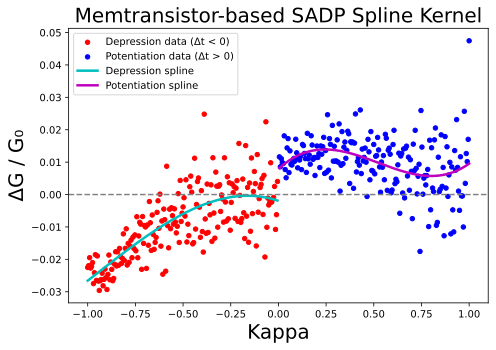

In [7]:
# Extract data from stdp_df
delta_t = stdp_df['Delta_t'].values
delta_g = stdp_df['Delta_G/G0'].values

# === Separate Δt into potentiation and depression ===
mask_pot = delta_t > 0
mask_dep = delta_t < 0

delta_t_pot = delta_t[mask_pot]
delta_g_pot = delta_g[mask_pot]
delta_t_dep = delta_t[mask_dep]
delta_g_dep = delta_g[mask_dep]

# === Sort before fitting splines ===
sort_pot = np.argsort(delta_t_pot)
sort_dep = np.argsort(delta_t_dep)

delta_t_pot_sorted = delta_t_pot[sort_pot]
delta_g_pot_sorted = delta_g_pot[sort_pot]

delta_t_dep_sorted = delta_t_dep[sort_dep]
delta_g_dep_sorted = delta_g_dep[sort_dep]

# === Fit Cubic Splines ===
#spline_pot = CubicSpline(delta_t_pot_sorted, delta_g_pot_sorted)
#spline_dep = CubicSpline(delta_t_dep_sorted, delta_g_dep_sorted)

# === Fit Smooth Splines ===
spline_pot = UnivariateSpline(delta_t_pot_sorted, delta_g_pot_sorted, s=0.1)
spline_dep = UnivariateSpline(delta_t_dep_sorted, delta_g_dep_sorted, s=0.01)


# === Evaluate for plotting ===
t_pot_fine = np.linspace(delta_t_pot_sorted.min(), delta_t_pot_sorted.max(), 300)
t_dep_fine = np.linspace(delta_t_dep_sorted.min(), delta_t_dep_sorted.max(), 300)
g_pot_fine = spline_pot(t_pot_fine)
g_dep_fine = spline_dep(t_dep_fine)

# === Plot ===
plt.figure(figsize=(7, 5))
plt.scatter(delta_t_dep, delta_g_dep, color='red', label='Depression data (Δt < 0)', s=20)
plt.scatter(delta_t_pot, delta_g_pot, color='blue', label='Potentiation data (Δt > 0)', s=20)
plt.plot(t_dep_fine, g_dep_fine, 'c-', lw=2.5, label='Depression spline')
plt.plot(t_pot_fine, g_pot_fine, 'm-', lw=2.5, label='Potentiation spline')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Pearson Correlation", fontsize=20)
plt.ylabel("ΔG / G₀", fontsize=20)
plt.title("Memtransistor-based SADP Spline Kernel", fontsize=20)
plt.legend()
plt.tight_layout()
plt.savefig('SCDP_pot_dep.png', dpi=300)
plt.show()


In [8]:
def create_ideal_sadp_kernel(num_points=300, tau_pot=0.3, tau_dep=0.3, A_pot=1e-4, A_dep=-1e-4, s_pot=0.1, s_dep=0.1):
    """
    Create an 'ideal' SADP kernel (synthetic) and fit splines.

    Parameters
    ----------
    num_points : int
        Number of discrete samples per side (potentiation/depression).
    tau_pot : float
        Decay constant for potentiation side (0 < tau_pot <= 1).
    tau_dep : float
        Decay constant for depression side (0 < tau_dep <= 1).
    A_pot : float
        Peak potentiation amplitude.
    A_dep : float
        Peak depression amplitude (negative).
    s_pot : float
        Smoothing parameter for potentiation spline.
    s_dep : float
        Smoothing parameter for depression spline.

    Returns
    -------
    spline_pot_ideal, spline_dep_ideal : UnivariateSpline
        Fitted splines for potentiation and depression.
    """

    # Agreement coordinate δ: positive = potentiation, negative = depression
    delta_t_pot = np.linspace(0, 1, num_points)
    delta_t_dep = np.linspace(-1, 0, num_points)

    # Ideal smooth exponential-like shape
    dG_pot = A_pot * np.exp(- (1 - delta_t_pot) / tau_pot)
    dG_dep = A_dep * np.exp(- (1 + delta_t_dep) / tau_dep)

    # Fit smooth splines
    spline_pot_ideal = UnivariateSpline(delta_t_pot, dG_pot, s=s_pot)
    spline_dep_ideal = UnivariateSpline(delta_t_dep, dG_dep, s=s_dep)

  

    # Plot for sanity check
    t_pot_fine = np.linspace(0, 1, 300)
    t_dep_fine = np.linspace(-1, 0, 300)
    plt.figure(figsize=(7, 5))
    plt.plot(t_dep_fine, spline_dep_ideal(t_dep_fine), 'c-', lw=2.5, label='Ideal Depression Spline')
    plt.plot(t_pot_fine, spline_pot_ideal(t_pot_fine), 'm-', lw=2.5, label='Ideal Potentiation Spline')
    plt.axhline(0, color='gray', linestyle='--')
    plt.xlabel("Kappa", fontsize=20)
    plt.ylabel("ΔG / G₀", fontsize=20)
    plt.title("Ideal SADP Spline Kernel", fontsize=20)
    plt.legend()
    plt.tight_layout()
    plt.savefig('SADP_pot_dep_ideal.png', dpi=300)
    plt.show()

    return spline_pot_ideal, spline_dep_ideal


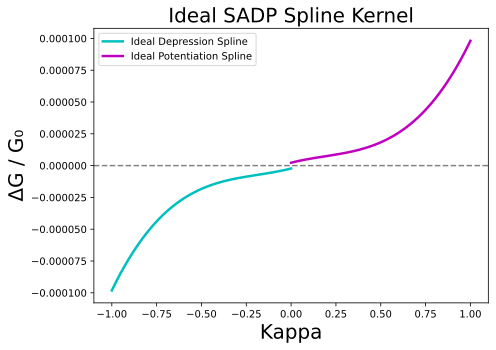

In [9]:
spline_pot_ideal, spline_dep_ideal = create_ideal_sadp_kernel()

In [10]:
def create_ideal_stdp_kernel(num_points=300, tau_pot=20.0, tau_dep=20.0, 
                             A_pot=1e-2, A_dep=-1e-2, 
                             s_pot=0.1, s_dep=0.1):
    """
    Create an 'ideal' STDP kernel (synthetic) and fit splines.

    Parameters
    ----------
    num_points : int
        Number of discrete samples per side (potentiation/depression).
    tau_pot : float
        Time constant for potentiation (ms).
    tau_dep : float
        Time constant for depression (ms).
    A_pot : float
        Peak potentiation amplitude.
    A_dep : float
        Peak depression amplitude (negative).
    s_pot : float
        Smoothing parameter for potentiation spline.
    s_dep : float
        Smoothing parameter for depression spline.

    Returns
    -------
    spline_pot, spline_dep : UnivariateSpline
        Fitted splines for potentiation and depression.
    """

    # Δt coordinate (in ms): pre-before-post (potentiation) > 0, pre-after-post (depression) < 0
    delta_t_pot = np.linspace(0, 100, num_points)   # LTP side
    delta_t_dep = np.linspace(-100, 0, num_points)  # LTD side

    # Exponential STDP form
    dW_pot = A_pot * np.exp(-delta_t_pot / tau_pot)
    dW_dep = A_dep * np.exp(delta_t_dep / tau_dep)  # note: delta_t_dep is negative

    # Fit splines
    spline_pot = UnivariateSpline(delta_t_pot, dW_pot, s=s_pot)
    spline_dep = UnivariateSpline(delta_t_dep, dW_dep, s=s_dep)

    # Plot (cyan = depression, magenta = potentiation)
    t_pot_fine = np.linspace(0, 100, 500)
    t_dep_fine = np.linspace(-100, 0, 500)

    plt.figure(figsize=(7, 5))
    plt.plot(t_dep_fine, spline_dep(t_dep_fine), 'c-', lw=2.5, label='Ideal LTD Spline')
    plt.plot(t_pot_fine, spline_pot(t_pot_fine), 'm-', lw=2.5, label='Ideal LTP Spline')
    plt.axhline(0, color='gray', linestyle='--')
    plt.xlabel("Δt (ms)", fontsize=20)
    plt.ylabel("ΔW", fontsize=20)
    plt.title("Ideal STDP Spline Kernel", fontsize=20)
    plt.legend()
    plt.tight_layout()
    plt.savefig('STDP_pot_dep_ideal.png', dpi=300)
    plt.show()

    return spline_pot, spline_dep


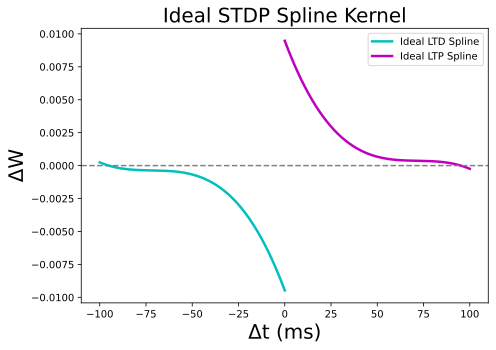

In [11]:
_,_=create_ideal_stdp_kernel()

In [12]:
def rate_coding(images, num_timesteps=10):
    """
    Convert images to spike trains with shape [batch, features, timesteps] using NumPy.
    Args:
        images: Normalized images (shape: [batch, height, width] or [batch, height*width])
        num_timesteps: Number of time steps (will be the last dimension).
    Returns:
        Spike trains (shape: [batch, features, timesteps])
    """
    if len(images.shape) > 2:
        images = images.reshape(images.shape[0], -1)  # Flatten to [batch, features]

    # Generate spikes: [batch, features, timesteps]
    spike_trains = np.random.rand(images.shape[0], images.shape[1], num_timesteps) < images[..., np.newaxis]
    return spike_trains.astype(np.float32)  # 1.0 = spike, 0.0 = no spike



def rate_code_labels(one_hot_labels, num_timesteps=10):
    """
    Rate code one-hot encoded labels into spike trains using TensorFlow.
    Args:
        one_hot_labels: tf.Tensor or np.ndarray of shape [batch, num_classes]
        num_timesteps: number of time steps
    Returns:
        spike_trains: tf.Tensor of shape [batch, num_classes, timesteps]
    """
    if isinstance(one_hot_labels, np.ndarray):
        one_hot_labels = tf.convert_to_tensor(one_hot_labels, dtype=tf.float32)

    if len(one_hot_labels.shape) > 2:
        one_hot_labels = tf.reshape(one_hot_labels, [tf.shape(one_hot_labels)[0], -1])

    rand_vals = tf.random.uniform(shape=[tf.shape(one_hot_labels)[0], tf.shape(one_hot_labels)[1], num_timesteps])
    spike_trains = tf.cast(rand_vals < tf.expand_dims(one_hot_labels, -1), tf.float32)
    return spike_trains

In [13]:
def burst_coding(images, num_timesteps=10, max_burst=5, seed=None):
    """
    Burst coding: More intense inputs produce more spikes spread over time.
    
    Args:
        images: [batch, height, width] or [batch, features], values ∈ [0, 1]
        num_timesteps: Total number of time steps.
        max_burst: Maximum number of spikes per input neuron.
        seed: Random seed for reproducibility.
        
    Returns:
        spike_trains: [batch, features, timesteps] spike array.
    """
    if seed is not None:
        np.random.seed(seed)

    if len(images.shape) > 2:
        images = images.reshape(images.shape[0], -1)

    batch_size, num_features = images.shape
    spike_trains = np.zeros((batch_size, num_features, num_timesteps), dtype=np.float32)

    # Determine how many spikes each neuron should fire
    bursts = (images * max_burst).astype(int)  # [batch, features]

    for b in range(batch_size):
        for f in range(num_features):
            n_spikes = bursts[b, f]
            if n_spikes > 0:
                spike_times = np.random.choice(num_timesteps, size=n_spikes, replace=False)
                spike_trains[b, f, spike_times] = 1.0

    return spike_trains


def burst_code_labels(one_hot_labels, num_timesteps=10, max_burst=5, seed=None):
    """
    Burst code one-hot labels into spike trains.
    
    Args:
        one_hot_labels: [batch, num_classes], values in {0.0, 1.0}
        num_timesteps: number of time steps
        max_burst: maximum number of spikes per active label
        seed: random seed (optional)
    
    Returns:
        spike_trains: [batch, num_classes, timesteps]
    """
    if seed is not None:
        tf.random.set_seed(seed)

    one_hot_labels = tf.cast(one_hot_labels, tf.float32)
    batch_size = tf.shape(one_hot_labels)[0]
    num_classes = tf.shape(one_hot_labels)[1]

    # Allocate output tensor
    spike_trains = tf.zeros([batch_size, num_classes, num_timesteps], dtype=tf.float32)

    # Broadcast one-hot labels into max_burst per label
    bursts = tf.cast(one_hot_labels * max_burst, tf.int32)

    for b in range(batch_size):
        for c in range(num_classes):
            n_spikes = bursts[b, c]
            if n_spikes > 0:
                spike_times = tf.random.shuffle(tf.range(num_timesteps))[:n_spikes]
                indices = tf.stack([tf.fill([n_spikes], b),
                                    tf.fill([n_spikes], c),
                                    spike_times], axis=1)
                updates = tf.ones(n_spikes, dtype=tf.float32)
                spike_trains = tf.tensor_scatter_nd_add(spike_trains, indices, updates)

    return spike_trains


In [14]:
def ttfs_coding(images, num_timesteps=10):
    """
    Time-to-First-Spike (TTFS) coding: Each neuron fires once, earlier for higher intensity.
    
    Args:
        images: [batch, height, width] or [batch, features], values ∈ [0, 1]
        num_timesteps: Total number of time steps.
        
    Returns:
        spike_trains: [batch, features, timesteps] spike array.
    """
    if len(images.shape) > 2:
        images = images.reshape(images.shape[0], -1)

    images = np.clip(images, 1e-5, 1.0)  # Avoid division by zero or NaN
    spike_times = (1.0 - images) * (num_timesteps - 1)  # Higher intensity → earlier spike
    spike_times = np.round(spike_times).astype(int)     # Discretize to integer timesteps

    batch_size, num_features = images.shape
    spike_trains = np.zeros((batch_size, num_features, num_timesteps), dtype=np.float32)

    # Set spike to 1 at the computed time
    for b in range(batch_size):
        spike_trains[b, np.arange(num_features), spike_times[b]] = 1.0

    return spike_trains


def ttfs_code_labels(one_hot_labels, num_timesteps=10):
    """
    TTFS encode labels: The active class spikes once, early; others don't spike.
    
    Args:
        one_hot_labels: [batch, num_classes], values in {0.0, 1.0}
        num_timesteps: number of time steps
    
    Returns:
        spike_trains: [batch, num_classes, timesteps]
    """
    one_hot_labels = tf.cast(one_hot_labels, tf.float32)
    batch_size = tf.shape(one_hot_labels)[0]
    num_classes = tf.shape(one_hot_labels)[1]

    # Use early spike time for active class
    spike_time = tf.zeros([batch_size, num_classes], dtype=tf.int32)
    spike_time = tf.where(one_hot_labels > 0, tf.zeros_like(spike_time), tf.fill([batch_size, num_classes], -1))

    # Create scatter indices and updates
    valid = tf.where(spike_time >= 0)
    updates = tf.ones(tf.shape(valid)[0], dtype=tf.float32)
    indices = tf.concat([valid, tf.zeros([tf.shape(valid)[0], 1], dtype=tf.int64)], axis=1)

    # Build spike train
    spike_trains = tf.scatter_nd(indices, updates, [batch_size, num_classes, num_timesteps])
    return spike_trains

In [15]:
def create_stdp_lookup_tensor(spline_pot, spline_dep, delta_min=-1, delta_max=1, resolution=1000):
    delta_range = np.linspace(delta_min, delta_max, resolution)
    stdp_vals = np.where(
        delta_range > 0,
        spline_pot(delta_range),
        np.where(delta_range < 0, spline_dep(delta_range), 0.0)
    )
    return tf.convert_to_tensor(stdp_vals, dtype=tf.float32), delta_min, delta_max, resolution

In [16]:
def stdp_lookup(delta_t, stdp_tensor, delta_min, delta_max, resolution):
    idx = tf.clip_by_value(
        tf.cast((delta_t - delta_min) * ((resolution - 1) / (delta_max - delta_min)), tf.int32),
        0, resolution - 1
    )
    return tf.gather(stdp_tensor, idx)

In [17]:
class RademacherInitializer(tf.keras.initializers.Initializer):
    def __call__(self, shape, dtype=None):
        dtype = dtype or tf.float32
        return tf.cast(tf.random.uniform(shape, minval=0, maxval=1) * 2 - 1, dtype)

In [18]:
def spike_function(x):
    return tf.cast(x > 0.0, tf.float32)


# --- Enhanced Spiking Dense Layer ---
class SpikingDense(tf.keras.layers.Layer):
    def __init__(self, units, threshold=0.5, num_timesteps=10, decay=0.9, 
                  w_init_std=0.01, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.threshold = threshold
        self.num_timesteps = num_timesteps
        self.decay = decay
        self.w_init_std = w_init_std

    def build(self, input_shape):
        self.input_dim = input_shape[-2]
        
        self.w = self.add_weight(
            shape=(self.input_dim, self.units),
            initializer=RademacherInitializer(),
            trainable=True,
            name="w")


    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        v_mem = tf.zeros((batch_size, self.units))
        outputs = tf.TensorArray(tf.float32, size=self.num_timesteps)
        
        for t in range(self.num_timesteps):
            x_t = inputs[:, :, t]
            
            # Enhanced current calculation
            I_t = tf.matmul(x_t, self.w)
            
            # Membrane potential update
            v_mem = v_mem * self.decay + I_t
            
            # Spike generation
            v_min = tf.reduce_min(v_mem, axis=1, keepdims=True)
            v_max = tf.reduce_max(v_mem, axis=1, keepdims=True)
            v_mem_norm = (v_mem - v_min) / (v_max - v_min + 1e-6)
            
            spike_out = spike_function(v_mem_norm - self.threshold)
            # Apply lateral inhibition
            inhibition_strength = 0.1  # tune this value
            mean_activity = tf.reduce_mean(spike_out, axis=1, keepdims=True)  # [B, 1]
            spike_out = tf.nn.relu(spike_out - inhibition_strength * mean_activity)
            v_mem = v_mem * (1 - spike_out)
            
            outputs = outputs.write(t, spike_out)
        
        return tf.transpose(outputs.stack(), [1, 2, 0])


def compute_pearson_matrix(pre_spikes_b, post_spikes_b):
    """
    Compute Pearson correlation matrix between pre- and post-synaptic spike trains.
    Args:
        pre_spikes_b: [input_nodes, T]
        post_spikes_b: [output_nodes, T]
    Returns:
        corr_matrix: [input_nodes, output_nodes] Pearson correlation coefficients
    """
    pre = tf.cast(pre_spikes_b, tf.float32)
    post = tf.cast(post_spikes_b, tf.float32)

    # Normalize along time
    pre_mean = tf.reduce_mean(pre, axis=1, keepdims=True)
    post_mean = tf.reduce_mean(post, axis=1, keepdims=True)

    pre_centered = pre - pre_mean
    post_centered = post - post_mean

    numerator = tf.matmul(pre_centered, post_centered, transpose_b=True)
    denom = tf.sqrt(
        tf.matmul(tf.reduce_sum(tf.square(pre_centered), axis=1, keepdims=True),
                  tf.transpose(tf.reduce_sum(tf.square(post_centered), axis=1, keepdims=True)))
    )

    corr_matrix = numerator / (denom + 1e-10)
    corr_matrix = tf.clip_by_value(corr_matrix, -1.0, 1.0)
    return corr_matrix


In [19]:
def build_snn_1layer(num_timesteps=5):
    inputs = tf.keras.Input(shape=(784, num_timesteps), name="input_layer")
    x = SpikingDense(
        400,
        threshold=0.5,
        num_timesteps=num_timesteps,
        name="output_layer"
    )(inputs)
    return tf.keras.Model(inputs=inputs, outputs=x)

def build_snn_2layer(num_timesteps=5):
    inputs = tf.keras.Input(shape=(784, num_timesteps), name="input_layer")
    x = SpikingDense(
        625,
        threshold=0.5,
        num_timesteps=num_timesteps,
        name="hidden_layer"
    )(inputs)
    x = SpikingDense(
        400,
        threshold=0.5,
        num_timesteps=num_timesteps,
        name="output_layer"
    )(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

def build_snn_1layer_small(num_timesteps=5):
    inputs = tf.keras.Input(shape=(784, num_timesteps), name="input_layer")
    x = SpikingDense(
        64,
        threshold=0.5,
        num_timesteps=num_timesteps,
        name="output_layer"
    )(inputs)
    return tf.keras.Model(inputs=inputs, outputs=x)

def build_snn_2layer_small(num_timesteps=5):
    inputs = tf.keras.Input(shape=(784, num_timesteps), name="input_layer")
    x = SpikingDense(
        625,
        threshold=0.5,
        num_timesteps=num_timesteps,
        name="hidden_layer"
    )(inputs)
    x = SpikingDense(
        64,
        threshold=0.5,
        num_timesteps=num_timesteps,
        name="output_layer"
    )(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

In [20]:
@tf.function
def apply_stdp_spline(V_pre, V_post, w, stdp_tensor,
               delta_min, delta_max, resolution,
               V_thresh=0.5, learning_rate=0.01,
               k=2):
    """
    STDP update using Pearson correlation instead of Kappa.
    """
    epsilon = 0.01

    B = tf.shape(V_pre)[0]

    pre_spikes = tf.cast(V_pre > V_thresh, tf.float32)
    post_spikes = tf.cast(V_post > V_thresh, tf.float32)

    dw_total = tf.zeros_like(w)

    for b in tf.range(B):
        corr_matrix = compute_pearson_matrix(pre_spikes[b], post_spikes[b])
        delta_w = stdp_lookup(corr_matrix, stdp_tensor, delta_min, delta_max, resolution)
        dw_total += delta_w

    dw_total = dw_total / tf.cast(B, tf.float32)
    w.assign_add(learning_rate * dw_total)

    sign_w = tf.sign(w)
    abs_w = tf.abs(w)
    clipped_abs_w = tf.maximum(abs_w, epsilon)
    w.assign(sign_w * clipped_abs_w)
    w.assign(tf.clip_by_value(w, -1.0, 1.0))



def train_on_chip_spline(model, x_train, y_train, spline_pot, spline_dep, 
                          epochs=10, batch_size=64, learning_rate=0.01, 
                          V_thresh=0.5,
                          test_image=None):
    """
    Train SNN using spline-based STDP with Pearson correlation.
    """
    learning_rate_tensor = tf.constant(learning_rate, dtype=tf.float32)
    V_thresh_tensor = tf.constant(V_thresh, dtype=tf.float32)

    stdp_tensor, delta_min, delta_max, resolution = create_stdp_lookup_tensor(
        spline_pot, spline_dep
    )

    dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    dataset = dataset.shuffle(buffer_size=len(x_train)) \
                     .batch(batch_size, drop_remainder=True) \
                     .prefetch(tf.data.AUTOTUNE)

    spiking_layers = [layer for layer in model.layers if isinstance(layer, SpikingDense)]
    w_norms = []

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        for x_batch, y_batch in tqdm(dataset, desc=f"Epoch {epoch+1}"):
            spike_activities = [x_batch]
            for layer in spiking_layers:
                spikes = layer(spike_activities[-1], training=True)
                spike_activities.append(spikes)

            for i in range(len(spiking_layers)):
                apply_stdp_spline(   # now uses Pearson correlation internally
                    V_pre=spike_activities[i],
                    V_post=spike_activities[i+1],
                    w=spiking_layers[i].w,
                    stdp_tensor=stdp_tensor,
                    delta_min=delta_min,
                    delta_max=delta_max,
                    resolution=resolution,
                    V_thresh=V_thresh_tensor,
                    learning_rate=learning_rate_tensor,
                )

        w_norms.append(tf.norm(spiking_layers[-1].w))
        avg_output_spikes = tf.reduce_mean(spike_activities[-1])
        print(f"  Avg Output Spikes: {avg_output_spikes:.4f}")
        print(f"  Final Layer Weight Norm: {tf.norm(spiking_layers[-1].w):.4f}")

        if test_image is not None:
            test_output = model(test_image)
            plot_spiking_activation_map(test_output)

    return np.array(w_norms)


In [21]:
@tf.function
def apply_stdp_spline_ideal(V_pre, V_post, w, stdp_tensor,
                             delta_min, delta_max, resolution,
                             V_thresh=0.5, learning_rate=0.01,
                             k=2):
    """
    Ideal STDP update using Pearson correlation.
    """
    epsilon = 0.01

    B = tf.shape(V_pre)[0]
    pre_spikes = tf.cast(V_pre > V_thresh, tf.float32)
    post_spikes = tf.cast(V_post > V_thresh, tf.float32)

    dw_total = tf.zeros_like(w)

    for b in tf.range(B):
        corr_matrix = compute_pearson_matrix(pre_spikes[b], post_spikes[b])
        delta_w = stdp_lookup(corr_matrix, stdp_tensor, delta_min, delta_max, resolution)
        dw_total += delta_w

    dw_total = dw_total / tf.cast(B, tf.float32)
    w.assign_add(learning_rate * dw_total)

    sign_w = tf.sign(w)
    abs_w = tf.abs(w)
    clipped_abs_w = tf.maximum(abs_w, epsilon)
    w.assign(sign_w * clipped_abs_w)
    w.assign(tf.clip_by_value(w, -1.0, 1.0))

    
    
def train_on_chip_spline_ideal(model, x_train, y_train,
                                spline_pot_ideal, spline_dep_ideal,
                                epochs=10, batch_size=64, learning_rate=0.01,
                                V_thresh=0.5,
                                test_image=None):
    """
    Train SNN using ideal spline-based STDP with Pearson correlation.
    """
    learning_rate_tensor = tf.constant(learning_rate, dtype=tf.float32)
    V_thresh_tensor = tf.constant(V_thresh, dtype=tf.float32)

    stdp_tensor, delta_min, delta_max, resolution = create_stdp_lookup_tensor(
        spline_pot_ideal, spline_dep_ideal
    )

    dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    dataset = dataset.shuffle(buffer_size=len(x_train)) \
                     .batch(batch_size, drop_remainder=True) \
                     .prefetch(tf.data.AUTOTUNE)

    spiking_layers = [layer for layer in model.layers if isinstance(layer, SpikingDense)]
    w_norms = []

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        for x_batch, y_batch in tqdm(dataset, desc=f"Epoch {epoch+1}"):
            spike_activities = [x_batch]
            for layer in spiking_layers:
                spikes = layer(spike_activities[-1], training=True)
                spike_activities.append(spikes)

            for i in range(len(spiking_layers)):
                apply_stdp_spline_ideal(   # Pearson correlation version
                    V_pre=spike_activities[i],
                    V_post=spike_activities[i+1],
                    w=spiking_layers[i].w,
                    stdp_tensor=stdp_tensor,
                    delta_min=delta_min,
                    delta_max=delta_max,
                    resolution=resolution,
                    V_thresh=V_thresh_tensor,
                    learning_rate=learning_rate_tensor,
                )

        w_norms.append(tf.norm(spiking_layers[-1].w))
        avg_output_spikes = tf.reduce_mean(spike_activities[-1])
        print(f"  Avg Output Spikes: {avg_output_spikes:.4f}")
        print(f"  Final Layer Weight Norm: {tf.norm(spiking_layers[-1].w):.4f}")

        if test_image is not None:
            test_output = model(test_image)
            plot_spiking_activation_map(test_output)

    return np.array(w_norms)


In [22]:
@tf.function
def apply_stdp_linear(V_pre, V_post, w,
               V_thresh=0.5, learning_rate=0.01,
               k=2):
    """
    Linear STDP update using Pearson correlation instead of Kappa.
    """
    epsilon = 0.01

    B = tf.shape(V_pre)[0]
    pre_spikes = tf.cast(V_pre > V_thresh, tf.float32)
    post_spikes = tf.cast(V_post > V_thresh, tf.float32)

    dw_total = tf.zeros_like(w)

    for b in tf.range(B):
        corr_matrix = compute_pearson_matrix(pre_spikes[b], post_spikes[b])
        dw_total += corr_matrix

    dw_total = dw_total / tf.cast(B, tf.float32)
    w.assign_add(learning_rate * dw_total)

    sign_w = tf.sign(w)
    abs_w = tf.abs(w)
    clipped_abs_w = tf.maximum(abs_w, epsilon)
    w.assign(sign_w * clipped_abs_w)
    w.assign(tf.clip_by_value(w, -1.0, 1.0))


def train_on_chip_linear(model, x_train, y_train,
                          epochs=10, batch_size=64, learning_rate=0.01, 
                          V_thresh=0.5,
                          test_image=None):
    """
    Train SNN using linear STDP updates with Pearson correlation.
    """
    learning_rate_tensor = tf.constant(learning_rate, dtype=tf.float32)
    V_thresh_tensor = tf.constant(V_thresh, dtype=tf.float32)
    
    dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    dataset = dataset.shuffle(buffer_size=len(x_train)) \
                     .batch(batch_size, drop_remainder=True) \
                     .prefetch(tf.data.AUTOTUNE)

    spiking_layers = [layer for layer in model.layers if isinstance(layer, SpikingDense)]
    w_norms = []

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        for x_batch, y_batch in tqdm(dataset, desc=f"Epoch {epoch+1}"):
            spike_activities = [x_batch]
            for layer in spiking_layers:
                spikes = layer(spike_activities[-1], training=True)
                spike_activities.append(spikes)

            for i in range(len(spiking_layers)):
                apply_stdp_linear(  # Pearson correlation version
                    V_pre=spike_activities[i],
                    V_post=spike_activities[i+1],
                    w=spiking_layers[i].w,
                    V_thresh=V_thresh_tensor,
                    learning_rate=learning_rate_tensor,
                )
                
        w_norms.append(tf.norm(spiking_layers[-1].w))
        avg_output_spikes = tf.reduce_mean(spike_activities[-1])
        print(f"  Avg Output Spikes: {avg_output_spikes:.4f}")
        print(f"  Final Layer Weight Norm: {tf.norm(spiking_layers[-1].w):.4f}")

        if test_image is not None:
            test_output = model(test_image)
            plot_spiking_activation_map(test_output)

    return np.array(w_norms)

In [23]:
def plot_spiking_activation_map(spiking_output, show_values=True, value_format=".2f"):
    """
    Plot spiking layer activation as a dot heatmap from a single model output.

    Parameters:
        spiking_output (tf.Tensor or np.ndarray): Shape (1, num_neurons, time_steps)
        show_values (bool): Whether to show numeric values on each dot
        value_format (str): Format string for displaying activation values (e.g. ".1f")
    """
    if isinstance(spiking_output, tf.Tensor):
        spiking_output = spiking_output.numpy()

    spike_activations = np.mean(spiking_output.squeeze(), axis=-1)
    num_neurons = spike_activations.shape[0]

    # Auto grid shape detection
    sqrt_n = int(np.sqrt(num_neurons))
    if sqrt_n * sqrt_n == num_neurons:
        rows, cols = sqrt_n, sqrt_n
    else:
        factors = [(i, num_neurons // i) for i in range(1, sqrt_n + 1) if num_neurons % i == 0]
        rows, cols = min(factors, key=lambda x: abs(x[0] - x[1]))

    activation_grid = spike_activations.reshape(rows, cols)

    # Generate centered coordinates
    x_coords, y_coords = np.meshgrid(np.arange(cols) + 0.5, np.arange(rows) + 0.5)
    x_coords_flat = x_coords.flatten()
    y_coords_flat = y_coords.flatten()
    activation_values = activation_grid.flatten()

    # --- Plot ---
    plt.figure(figsize=(6, 6))  # Fixed figure size
    plt.scatter(x_coords_flat, y_coords_flat, c=activation_values, cmap='hot', s=70, alpha=0.85)

    if show_values:
        for (x, y, val) in zip(x_coords_flat, y_coords_flat, activation_values):
            plt.text(
                x, y, format(val, value_format),
                ha='center', va='center',
                fontsize=3, color='#888888'
            )

    plt.gca().invert_yaxis()
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.show()

In [24]:
# --- Build classifier on top of a frozen model ---
def build_frozen_classifier(frozen_model, num_timesteps=10):
    frozen_model.trainable = False  # freeze base SNN

    inputs = tf.keras.Input(shape=(784, num_timesteps), name="input_layer")

    # Pass through frozen SNN
    x = frozen_model(inputs)

    # Flatten across neurons and time
    x = tf.keras.layers.Flatten()(x)

    # Trainable classification head
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    outputs = tf.keras.layers.Dense(10, activation='softmax', name="output_layer")(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

# --- Train and evaluate all models ---
def train_and_evaluate_all(models_dict, x_train, y_train_orig, x_test, y_test_orig,
                           num_timesteps=10, epochs=10, batch_size=64):
    results = {}

    for name, base_model in models_dict.items():
        print(f"\n⚙️  Processing model: {name}")

        # Build and compile classifier
        classifier = build_frozen_classifier(base_model, num_timesteps)
        classifier.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),  # or any other LR
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

        # Train classifier head
        history= classifier.fit(x_train, y_train_orig,
                       validation_split=0.1,
                       epochs=epochs,
                       batch_size=batch_size,
                       verbose=1)

        # Predict and evaluate
        y_pred_probs = classifier.predict(x_test)
        y_pred = np.argmax(y_pred_probs, axis=1)
        y_true = np.argmax(y_test_orig, axis=1)

        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='macro')
        cm = confusion_matrix(y_true, y_pred)

        results[name] = {'accuracy': acc, 'confusion_matrix': cm, 'F1': f1}

        # --- Plot confusion matrix ---
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.title(f"{name}\nAccuracy: {acc:.4f}")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.tight_layout()
        plt.show()

    return results, history